*** proactive_steps_sm[-1]: 997959


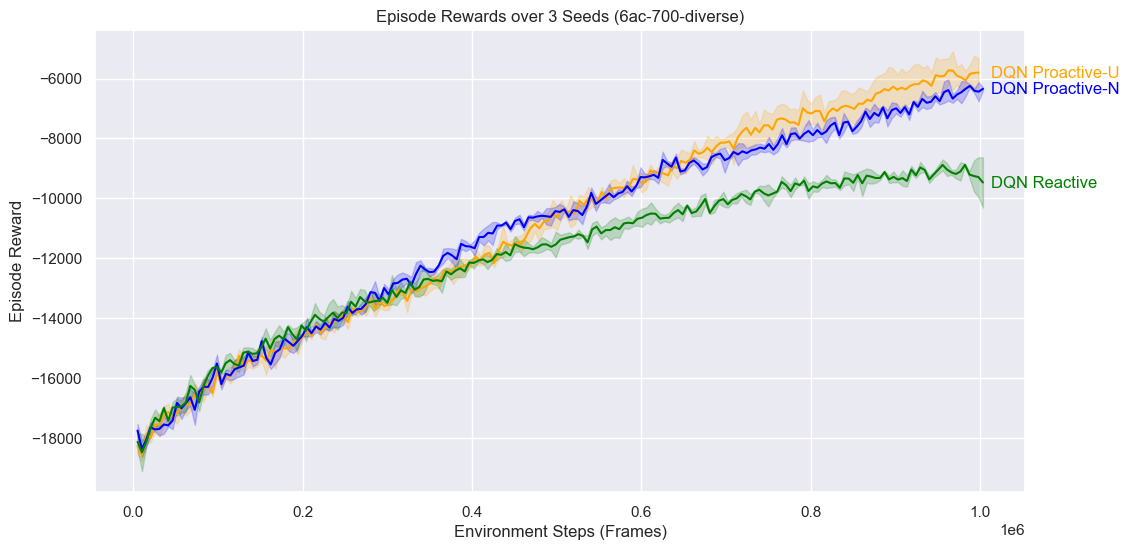

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_results_folder = "../5f-config2-big-run"  # folder containing scenario subfolders

def smooth(data, window=10):
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Scan the base folder for scenario subdirectories
scenario_folders = [
    f for f in os.listdir(base_results_folder) 
    if os.path.isdir(os.path.join(base_results_folder, f))
]

sns.set(style="darkgrid")

for scenario in scenario_folders:
    # Path to the numpy folder inside this scenario
    numpy_dir = os.path.join(base_results_folder, scenario, "numpy")
    if not os.path.exists(numpy_dir):
        # If there's no numpy folder, skip this scenario
        continue
    
    # Load the arrays
    try:
        all_myopic_runs = np.load(os.path.join(numpy_dir, "all_myopic_runs.npy"))
        all_myopic_steps_runs = np.load(os.path.join(numpy_dir, "all_myopic_steps_runs.npy"))
        all_proactive_runs = np.load(os.path.join(numpy_dir, "all_proactive_runs.npy"))
        all_proactive_steps_runs = np.load(os.path.join(numpy_dir, "all_proactive_steps_runs.npy"))
        all_reactive_runs = np.load(os.path.join(numpy_dir, "all_reactive_runs.npy"))
        all_reactive_steps_runs = np.load(os.path.join(numpy_dir, "all_reactive_steps_runs.npy"))
        
        # Test rewards might not exist if cross_val_flag was False
        test_rewards_myopic_path = os.path.join(numpy_dir, "all_test_rewards_myopic.npy")
        test_rewards_proactive_path = os.path.join(numpy_dir, "all_test_rewards_proactive.npy")
        test_rewards_reactive_path = os.path.join(numpy_dir, "all_test_rewards_reactive.npy")

        test_rewards_myopic = np.load(test_rewards_myopic_path) if os.path.exists(test_rewards_myopic_path) else None
        test_rewards_proactive = np.load(test_rewards_proactive_path) if os.path.exists(test_rewards_proactive_path) else None
        test_rewards_reactive = np.load(test_rewards_reactive_path) if os.path.exists(test_rewards_reactive_path) else None

    except FileNotFoundError as e:
        print(f"Missing files in {numpy_dir}, skipping scenario '{scenario}'. Error: {e}")
        continue

    # Compute means and std
    myopic_mean = all_myopic_runs.mean(axis=0)
    myopic_std = all_myopic_runs.std(axis=0)
    proactive_mean = all_proactive_runs.mean(axis=0)
    proactive_std = all_proactive_runs.std(axis=0)
    reactive_mean = all_reactive_runs.mean(axis=0)
    reactive_std = all_reactive_runs.std(axis=0)

    myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)
    proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)
    reactive_steps_mean = all_reactive_steps_runs.mean(axis=0).astype(int)

    # Smooth data for plotting 

    smooth_window = 1
    
    myopic_mean_sm = smooth(myopic_mean, smooth_window)
    myopic_std_sm = smooth(myopic_std, smooth_window)
    myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

    proactive_mean_sm = smooth(proactive_mean, smooth_window)
    proactive_std_sm = smooth(proactive_std, smooth_window)
    proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

    reactive_mean_sm = smooth(reactive_mean, smooth_window)
    reactive_std_sm = smooth(reactive_std, smooth_window)
    reactive_steps_sm = reactive_steps_mean[:len(reactive_mean_sm)]

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="darkgrid")

    plt.figure(figsize=(12,6))

    # Plot DQN Proactive-U
    plt.plot(proactive_steps_sm, proactive_mean_sm, color='orange')
    plt.fill_between(proactive_steps_sm, 
                    proactive_mean_sm - proactive_std_sm, 
                    proactive_mean_sm + proactive_std_sm, 
                    alpha=0.2, color='orange')
    
    # calculate the largest value of all three lines
    max_value = max(proactive_steps_sm[-1], myopic_steps_sm[-1], reactive_steps_sm[-1])
    padding = 10000
    label_x_value = max_value + padding
    # Add label at the end of the line
    plt.text(label_x_value, proactive_mean_sm[-1], "DQN Proactive-U", 
            color='orange', va='center', ha='left')
    

    print(f"*** proactive_steps_sm[-1]: {proactive_steps_sm[-1]}")

    # Plot DQN Proactive-N
    plt.plot(myopic_steps_sm, myopic_mean_sm, color='blue')
    plt.fill_between(myopic_steps_sm, 
                    myopic_mean_sm - myopic_std_sm, 
                    myopic_mean_sm + myopic_std_sm, 
                    alpha=0.2, color='blue')
    # Add label at the end of the line
    plt.text(label_x_value, myopic_mean_sm[-1], "DQN Proactive-N", 
            color='blue', va='center', ha='left')

    # Plot DQN Reactive
    plt.plot(reactive_steps_sm, reactive_mean_sm, color='green')
    plt.fill_between(reactive_steps_sm, 
                    reactive_mean_sm - reactive_std_sm, 
                    reactive_mean_sm + reactive_std_sm, 
                    alpha=0.2, color='green')
    # Add label at the end of the line
    plt.text(label_x_value, reactive_mean_sm[-1], "DQN Reactive", 
            color='green', va='center', ha='left')

    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    if len(all_myopic_runs) > 1:
        plt.title(f"Episode Rewards over {len(all_myopic_runs)} Seeds ({scenario})")
    else:
        plt.title(f"Episode Rewards ({scenario})")

    # No legend, since we labeled lines directly
    # plt.legend(frameon=False)

    plt.grid(True)
    plt.show()


    # # If test rewards exist, plot them as well
    # if test_rewards_myopic is not None and len(test_rewards_myopic) > 0:
    #     # Just plot the first seed's test rewards for demonstration
    #     plt.figure(figsize=(12,6))
    #     plt.plot(test_rewards_myopic[0], label="Myopic", color='blue')
    #     plt.plot(test_rewards_proactive[0], label="Proactive", color='orange')
    #     plt.plot(test_rewards_reactive[0], label="Reactive", color='green')
    #     plt.xlabel("Episode")
    #     plt.ylabel("Test Reward")
    #     plt.title(f"Test Rewards over Episodes (DQN, {scenario})")
    #     plt.legend(frameon=False)
    #     plt.grid(True)
    #     plt.show()



In [2]:
# Load and print config values from config.csv
config_df = pd.read_csv(base_results_folder + "/config.csv")
for column in config_df.columns:
    print(f"{column}= {config_df[column].iloc[0]}")


np= <module 'numpy' from '/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv/lib/python3.10/site-packages/numpy/__init__.py'>
MAX_AIRCRAFT= 6
MAX_FLIGHTS_PER_AIRCRAFT= 20
ROWS_STATE_SPACE= 7
COLUMNS_STATE_SPACE= 63
ACTION_SPACE_SIZE= 147
DEPARTURE_AFTER_END_RECOVERY= 1
TIMESTEP_HOURS= 1
DUMMY_VALUE= -999
RESOLVED_CONFLICT_REWARD= 5000
DELAY_MINUTE_PENALTY= 11.5
MAX_DELAY_PENALTY= 2500
NO_ACTION_PENALTY= 0
CANCELLED_FLIGHT_PENALTY= 5000
LAST_MINUTE_THRESHOLD= 120
LAST_MINUTE_FLIGHT_PENALTY= 455
AHEAD_BONUS_PER_MINUTE= 0.1
TIME_MINUTE_PENALTY= 1
TERMINATION_REWARD= 500
MIN_TURN_TIME= 0
MIN_BREAKDOWN_PROBABILITY= 0
DEBUG_MODE= False
DEBUG_MODE_TRAINING= False
DEBUG_MODE_REWARD= False
DEBUG_MODE_PRINT_STATE= False
DEBUG_MODE_CANCELLED_FLIGHT= False
DEBUG_MODE_VISUALIZATION= False
DEBUG_MODE_BREAKDOWN= False
DEBUG_MODE_ACTION= False
DEBUG_MODE_STOPPING_CRITERIA= False
DEBUG_MODE_SCHEDULING= False
DEBUG_MODE_REWARD_LAST_MINUTE_PENALTY= False
DEBUG_MODE_REWARD_RESOLVED_CONFLICTS= False


Final Average Rewards (averaged over scenarios and then over runs):
myopic-training_506.zip: -9339.002800000006
proactive-training_513.zip: -9335.642171428572
reactive-training_518.zip: -10231.47937142858

Final Std of Rewards (across runs):
myopic-training_506.zip: 294.7779794410424
proactive-training_513.zip: 188.651254359853
reactive-training_518.zip: 161.89050047015814

Final Average Runtime (averaged over scenarios and then over runs):
myopic-training_506.zip: 0.00465268189566476
proactive-training_513.zip: 0.004573705264500209
reactive-training_518.zip: 0.004653797422136579

Final Std of Runtime (across runs):
myopic-training_506.zip: 3.766608159595545e-05
proactive-training_513.zip: 5.260034833453906e-05
reactive-training_518.zip: 4.480434225240008e-05

Pairwise p-values for REWARDS:
                           myopic-training_506.zip proactive-training_513.zip  \
myopic-training_506.zip                        NaN                   0.958935   
proactive-training_513.zip          

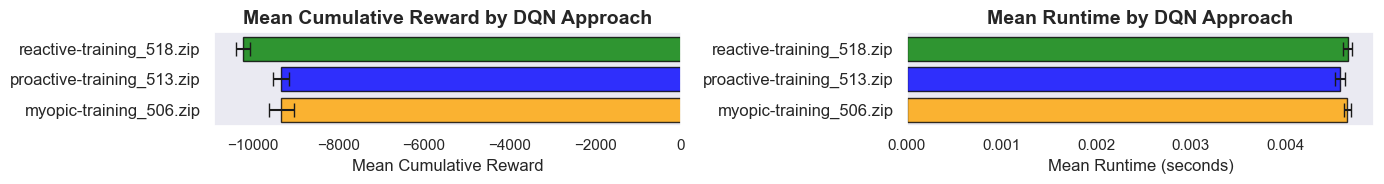

In [3]:
import sys
sys.path.append("..")
import os
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
import torch
import time
import re
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
from src.config import *

def run_inference_dqn(model_path, scenario_folder, env_type, seed):
    # Load scenario data
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict,
        env_type=env_type
    )

    # Load model
    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Reset the environment
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    # Start timing the inference
    start_time = time.time()

    while not done_flag and step_num < max_steps:
        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

        # Get action mask
        action_mask = obs.get('action_mask', None)
        if action_mask is None:
            raise ValueError("Action mask is missing in the observation!")

        # Get Q-values
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        # Mask invalid actions
        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        action = np.argmax(masked_q_values)

        # Step environment
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    # End timing
    end_time = time.time()
    runtime = end_time - start_time

    return total_reward, step_num, runtime

# Example seed and training IDs
seed = 26
training_id_myopic = 506
training_id_proactive = 513
training_id_reactive = 518

model_to_compare = [
    f"../trained_models/dqn/6ac-350-diverse/{seed}/training_{training_id_myopic}/myopic-training_{training_id_myopic}.zip",
    f"../trained_models/dqn/6ac-350-diverse/{seed}/training_{training_id_proactive}/proactive-training_{training_id_proactive}.zip",
    f"../trained_models/dqn/6ac-350-diverse/{seed}/training_{training_id_reactive}/reactive-training_{training_id_reactive}.zip",
]

# Define the scenario folder set
SCENARIO_FOLDER = "../data/Testing/6ac-350-diverse/"

# Extract all scenario folders
scenario_folders = [os.path.join(SCENARIO_FOLDER, d) for d in os.listdir(SCENARIO_FOLDER) 
                    if os.path.isdir(os.path.join(SCENARIO_FOLDER, d))]
scenario_folders.sort()

def extract_env_type(model_path):
    match = re.search(r'/(myopic|proactive|reactive)', model_path)
    if not match:
        raise ValueError(f"Model path {model_path} does not contain a valid environment type!")
    return match.group(1)

# Number of runs
N_RUNS = 5

num_scenarios = len(scenario_folders)
num_models = len(model_to_compare)

results_all_runs = np.zeros((N_RUNS, num_scenarios, num_models))
runtime_all_runs = np.zeros((N_RUNS, num_scenarios, num_models))

base_seed = 12345

for run_idx in range(N_RUNS):
    current_seed = base_seed + run_idx
    
    for m_idx, model_path in enumerate(model_to_compare):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
            
        env_type = extract_env_type(model_path)
        
        for s_idx, scenario_folder in enumerate(scenario_folders):
            if not os.path.exists(scenario_folder):
                raise FileNotFoundError(f"Scenario folder not found: {scenario_folder}")
            
            total_reward, steps, runtime = run_inference_dqn(model_path, scenario_folder, env_type, current_seed)
            # Store results
            results_all_runs[run_idx, s_idx, m_idx] = total_reward
            runtime_all_runs[run_idx, s_idx, m_idx] = runtime

# Compute run-level means for rewards and runtime
run_mean_rewards = np.mean(results_all_runs, axis=1)  # shape: (N_RUNS, num_models)
run_mean_runtime = np.mean(runtime_all_runs, axis=1)  # shape: (N_RUNS, num_models)

# Compute final mean and std across runs
final_mean_rewards = np.mean(run_mean_rewards, axis=0)
final_std_rewards = np.std(run_mean_rewards, axis=0)

final_mean_runtime = np.mean(run_mean_runtime, axis=0)
final_std_runtime = np.std(run_mean_runtime, axis=0)

model_names = [os.path.basename(m) for m in model_to_compare]

# Print final results
print("Final Average Rewards (averaged over scenarios and then over runs):")
for m_name, val in zip(model_names, final_mean_rewards):
    print(f"{m_name}: {val}")

print("\nFinal Std of Rewards (across runs):")
for m_name, val in zip(model_names, final_std_rewards):
    print(f"{m_name}: {val}")

print("\nFinal Average Runtime (averaged over scenarios and then over runs):")
for m_name, val in zip(model_names, final_mean_runtime):
    print(f"{m_name}: {val}")

print("\nFinal Std of Runtime (across runs):")
for m_name, val in zip(model_names, final_std_runtime):
    print(f"{m_name}: {val}")

# Pairwise t-tests for rewards
print("\nPairwise p-values for REWARDS:")
p_value_rewards = pd.DataFrame(index=model_names, columns=model_names)
for i in range(num_models):
    for j in range(num_models):
        if i == j:
            p_value_rewards.iloc[i, j] = np.nan
        else:
            stat, p_val = ttest_rel(run_mean_rewards[:, i], run_mean_rewards[:, j])
            p_value_rewards.iloc[i, j] = p_val
print(p_value_rewards)

# Pairwise t-tests for runtime
print("\nPairwise p-values for RUNTIME:")
p_value_runtime = pd.DataFrame(index=model_names, columns=model_names)
for i in range(num_models):
    for j in range(num_models):
        if i == j:
            p_value_runtime.iloc[i, j] = np.nan
        else:
            stat, p_val = ttest_rel(run_mean_runtime[:, i], run_mean_runtime[:, j])
            p_value_runtime.iloc[i, j] = p_val
print(p_value_runtime)

# Plotting using the actual calculated values
labels = model_names
bar_colors = ['orange', 'blue', 'green'][:len(labels)]  # In case you have fewer or more models

y = np.arange(len(labels))  # the label locations



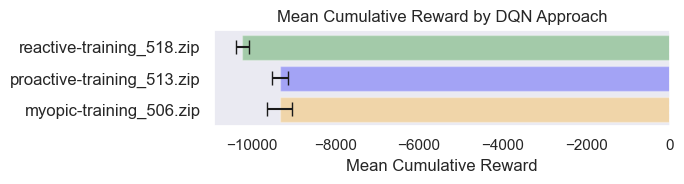

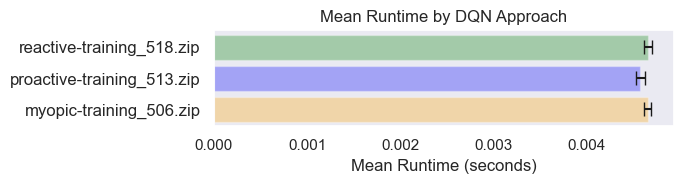

In [7]:


# Plot rewards
plt.figure(figsize=(7, 2))
plt.barh(y, final_mean_rewards, xerr=final_std_rewards, capsize=5, color=bar_colors, alpha=0.3)
plt.xlabel('Mean Cumulative Reward', fontsize=12)
plt.yticks(y, labels, fontsize=12)
plt.axvline(x=0, color='gray', linewidth=1, linestyle='--')
plt.title('Mean Cumulative Reward by DQN Approach')
plt.grid(alpha=0)
plt.tight_layout()
plt.show()

# Plot runtime
plt.figure(figsize=(7, 2))
plt.barh(y, final_mean_runtime, xerr=final_std_runtime, capsize=5, color=bar_colors, alpha=0.3)
plt.xlabel('Mean Runtime (seconds)', fontsize=12)
plt.yticks(y, labels, fontsize=12)
plt.title('Mean Runtime by DQN Approach')
plt.grid(alpha=0)
plt.tight_layout()
plt.show()